In [1]:
########################################################################################################################################
#         CSR   =   Compressed Sparse Row
#         CSC   =   Compressed Sparse Column
#         DCSR  =   Doubly Compressed Sparse Row
#         DD    =   Dense Dense (TACO also supports Dense, Dense format i.e. no compression)
#         NDD   =   Naive Implementation (cpp bidimensional vectors)
########################################################################################################################################
#         InputConv   =   Receives the input as bidimensional vectors and then converts to a TACO tensor
#         sampling    =   Sequential implementation of the sampling method i.e. transverse the tensor to count zeros
#         psampling   =   Parallel implementation of sampling using openmp
#         none        =   No sampling
########################################################################################################################################
# Example: DCSR + psampling (Last graph)
# The time represents the input conversion + parallel sampling + the expression C = A*B where all tensors are in DSCR format

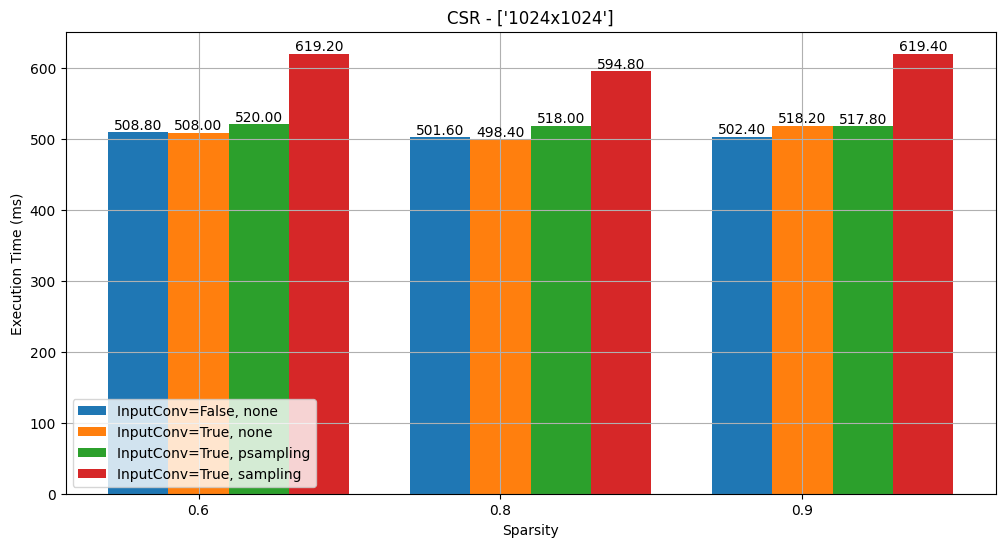

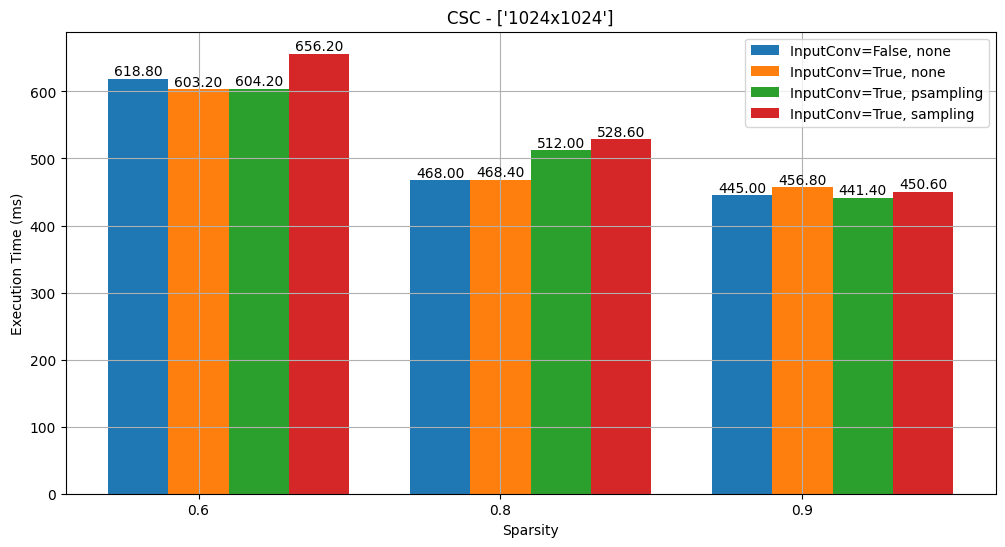

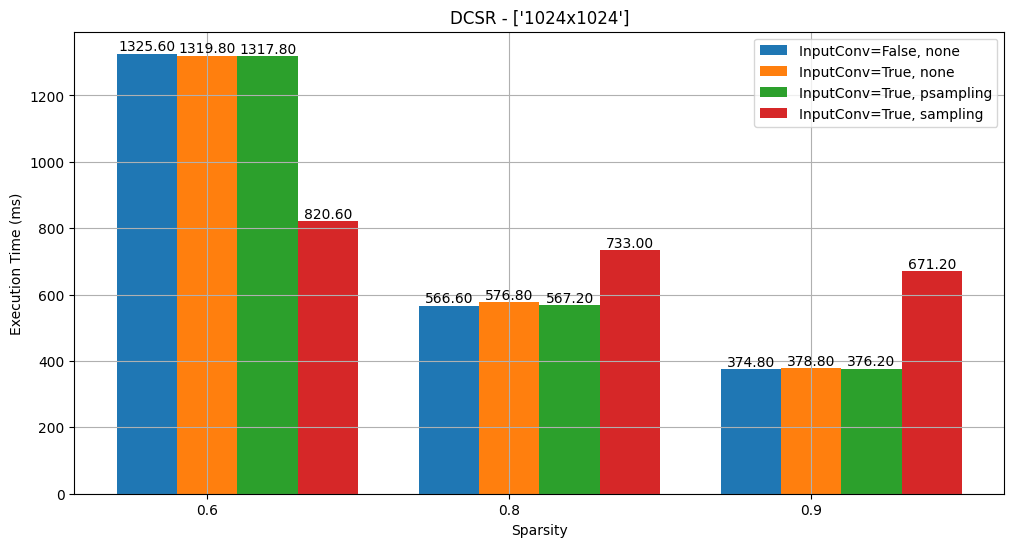

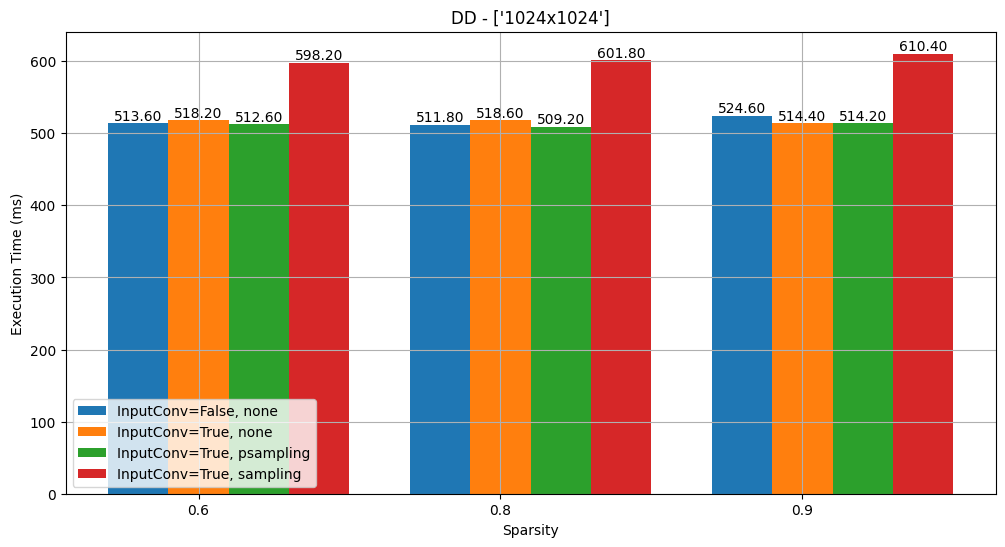

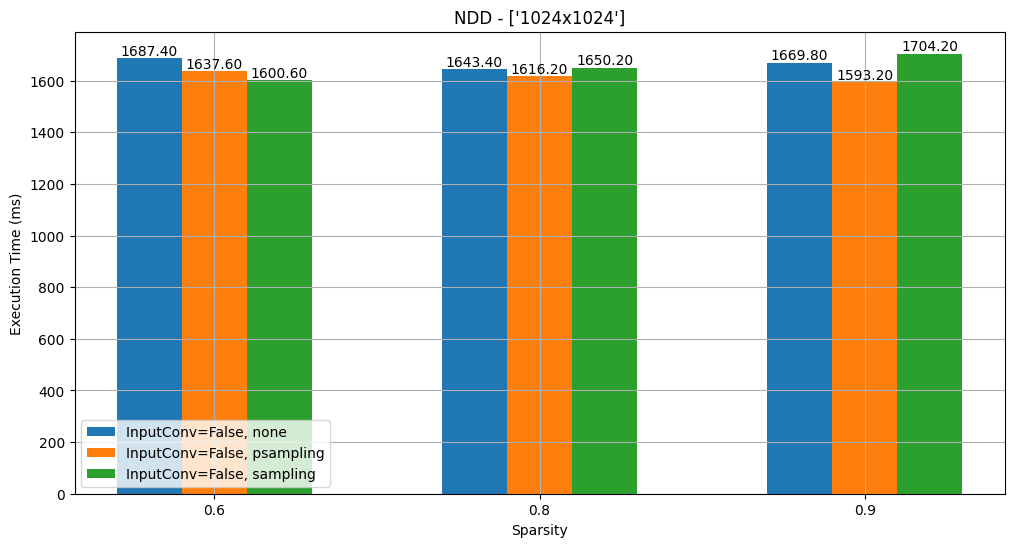

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# File path (Update this with your actual file path)
file_path = "1024-mac.out"

def parse_benchmark_file(file_path):
    data = []
    pattern = re.compile(r"'(\w+)'\]:(\d+\.\d+)ms")
    
    with open(file_path, "r") as file:
        for line in file:
            args = line.split(', ')
            rows, cols = int(args[0][1:]), int(args[1])
            formt = args[2].replace('\'', '')
            dense_out = args[3] == "True"
            sparsity = float(args[4])
            input_conv = args[5]
            size = f"{rows}x{cols}"
            match = pattern.match(args[6])
            if match:
                sampling = match.group(1)
                exec_time = match.group(2)
                data.append([size, formt, dense_out, sparsity, input_conv, sampling, float(exec_time)])
    return pd.DataFrame(data, columns=["Size", "Format", "Dense-Out", "Sparsity", "Input Conv", "Sampling Method", "Time (ms)"])

def plot_benchmark(df):
    formats = df["Format"].unique()
    
    for format_type in formats:
        plt.figure(figsize=(12, 6))
        subset = df[df["Format"] == format_type]
        sparsity_levels = sorted(subset["Sparsity"].unique())
        width = 0.2
        
        labels = []
        bar_positions = np.arange(len(sparsity_levels))
        
        for idx, (input_conv, method) in enumerate(subset.groupby(["Input Conv", "Sampling Method"])):
            input_conv_flag, method_name = input_conv
            times = []
            
            for sparsity in sparsity_levels:
                time = subset[(subset["Sparsity"] == sparsity) & 
                              (subset["Input Conv"] == input_conv_flag) & 
                              (subset["Sampling Method"] == method_name)]["Time (ms)"].values
                times.append(time[0] if len(time) > 0 else 0)
            
            bars = plt.bar(bar_positions + idx * width, times, width=width, label=f"InputConv={input_conv_flag}, {method_name}")
            
            # **Add text on top of bars**
            for bar in bars:
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

        size = df["Size"].unique()
        plt.xlabel("Sparsity")
        plt.ylabel("Execution Time (ms)")
        plt.title(f"{format_type} - {size}")
        plt.xticks(bar_positions + width, sparsity_levels)
        plt.legend()
        plt.grid()
        plt.show()

df = parse_benchmark_file(file_path)
# Plotting only the compressed output
df = df[(df["Format"] == 'DCSR') | (df["Dense-Out"] == False)]
#print(df)
%matplotlib inline
plot_benchmark(df)

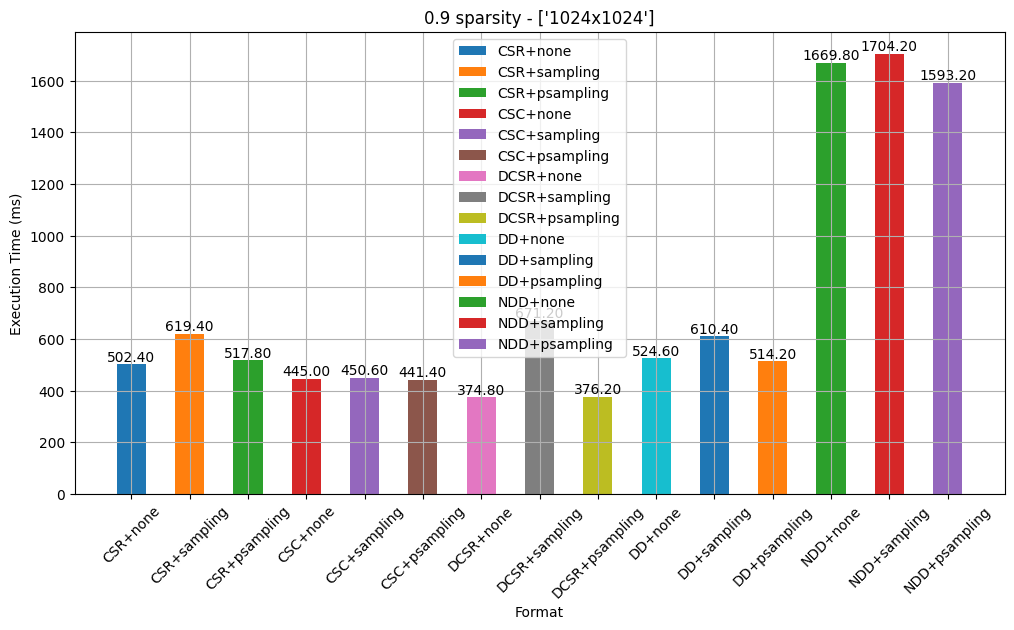

In [3]:
import itertools
def plot_density_0_9(df):
    df_filtered = df[df["Sparsity"] == 0.9]

    plt.figure(figsize=(12, 6))
    formats = df_filtered["Format"].unique()
    methods = df_filtered["Sampling Method"].unique()
    formats_methods = list(itertools.product(formats, methods))

    bar_width = 0.5
    x_positions = list(range(len(formats_methods)))  # Adjusted x positions for bars
    
    bars = []
    
    for (x_pos, (formt, method)) in zip(x_positions, formats_methods):
        subset = df_filtered[(df_filtered["Format"] == formt) & (df_filtered["Sampling Method"] == method)]
        if not subset.empty:
            exec_t = subset["Time (ms)"].values[0]
            bar = plt.bar(x_pos, exec_t, width=bar_width, label=f'{formt}+{method}')
            bars.append((bar, exec_t, x_pos))  # Store for adding text

    # **Add text on top of bars**
    for bar, yval, x_pos in bars:
        plt.text(x_pos, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

    size = df["Size"].unique()
    plt.xlabel("Format")
    plt.ylabel("Execution Time (ms)")
    plt.xticks(x_positions, [f"{f}+{m}" for f, m in formats_methods], rotation=45)
    plt.title(f"0.9 sparsity - {size}")
    plt.legend()
    plt.grid()
    plt.show()

%matplotlib inline
plot_density_0_9(df)